In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List

In [15]:
@njit(nogil=True)
def pbc_dist(a, b, P):
    d = abs(a-b)
    return min(d, P-d)

@njit
def move_front(u, delta, origin, k, M):
    L = len(u)
    for i in range(k):
        idx = (i+origin)%L
        new_u = (u[idx] + delta)%M
        u[idx] = new_u


@njit
def check_front(u, V, delta, origin, k):
    L = V.shape[0]
    M = V.shape[1]
    left_d = pbc_dist(u[origin], u[(origin-1)%L], M)
    right_d = pbc_dist(u[(origin + k-1)%L],  u[(origin+k)%L], M)
    if(left_d >= 1 or right_d >= 1):
        return 0, False
    dE = 1.0
    for i in range(k):
        u_i = u[(origin+i)%L]
        dE = dE +  (V[i, (u_i+delta) % M] - V[i, u_i])
    return dE, True

In [16]:
np.random.seed(0)
L = 128
M = 2*L
V = np.random.normal(size=(L, M))
u = np.zeros(L, dtype=int) #indices along M
f = 0.0

In [17]:
while(True):
    stop = False
    target_k = -1
    target_origin = -1
    target_delta = 0
    for k in np.arange(1, L):
        if(stop):
            break
        for origin in range(0, L):
            if(stop):
                break
            for delta in [-1,1]:
                if(stop):
                    break
                dE_front, status = check_front(u, V, delta=1, origin=origin, k=k)
                if(status):
                    dE = dE_front - f*k*delta
                    if(dE < 0):
                        stop = True
                        target_k = k
                        target_origin  = origin
                        target_delta = delta
    if(stop is False):
        break
    else:
        move_front(u, target_delta, target_origin, target_k, M)

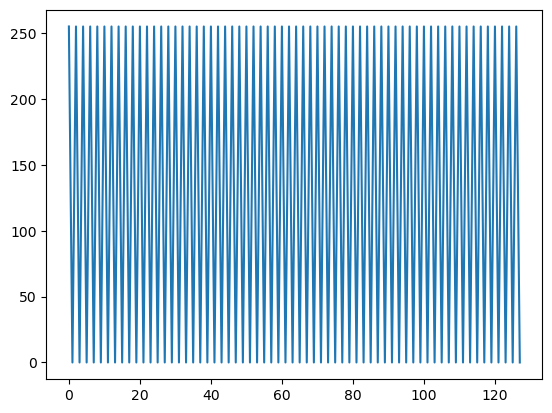

In [19]:
plt.plot(u)

In [ ]:
@njit
def get_nn_list(L):
    nn_list = np.zeros((L*L, 4), dtype=np.int64)
    for i in range(L):
        for j in range(L):
            index = i*L+j
            nn_list[index,0] = ((i+1) % L)*L+j
            nn_list[index,1] = ((i-1) % L)*L+j
            nn_list[index,2] = i*L + ((j+1)%L)
            nn_list[index,3] = i*L + ((j-1)%L)
            #nn_list[index,4] = ((i-1) % L)*L+(j-1)%L
            #nn_list[index,5] = ((i-1) % L)*L+(j+1)%L
            #nn_list[index,6] = ((i+1) % L)*L+(j-1)%L
            #nn_list[index,7] = ((i+1) % L)*L+(j+1)%L
    return nn_list

In [ ]:
@njit
def compute_dE(s_pos,nn_list,S, h, Hd):
    return 2*S[s_pos]*(np.sum(S[nn_list[s_pos,:]])+Hd+h[s_pos])

@njit
def monte_carlo_update(pos_list,nn_list,S, h, Hd):
    pos_index = np.random.choice(len(pos_list))
    pos = pos_list.pop(pos_index)
    S[pos] = -S[pos]
    for s_pos in nn_list[pos,:]:
        #dE = 2*S[s_pos]*(np.sum(S[nn_list[s_pos,:]])+Hd+h[s_pos])
        dE = compute_dE(s_pos, nn_list, S, h, Hd)
        if(dE<0):
            if(not s_pos in pos_list):
                pos_list.append(s_pos)
    return S[pos]

In [ ]:
L = 1024
S = -np.ones(L*L, dtype=int)
bubble = True
if(bubble):
    mask = (np.arange(0,L)[:,None]-L/2)**2+(np.arange(0,L)[None,:]-L/2)**2 <= (L/10)**2
else:
    mask = (np.arange(0,L)[:,None] < L/10)*np.ones(L, dtype=bool)[None,:]
S[mask.flatten()] = 1
correlated_disorder = False
if(not correlated_disorder):
    delta = 1
    h = np.random.uniform(-delta, delta, size=(L,L))

else:
    q = fft.fftfreq(L)
    Hurst = 2
    fourier_kernel = (4-2*np.cos(2*np.pi*q[:,None])-2*np.cos(2*np.pi*q[None,:]))**(Hurst/2)
    h = (fft.ifft2(fft.fft2(np.random.normal(size=(L,L)))*fourier_kernel).real*delta).flatten()
    h = (h-h.mean())/h.std()
H = 1.3
nn_list = get_nn_list(L)
pos_list = List()
for s_pos in range(0, L*L):
    if(compute_dE(s_pos, nn_list, S, h, H)<0):
        pos_list.append(s_pos)

In [ ]:
N_t = []
area = [np.sum(S==1).sum()]
snaps = []
interfaces = []
for t in range(500000):
    if(len(pos_list) == 0):
        print('Stop')
        break
    if(t%5000==0):
        print(t)
        snaps.append(np.copy(S.reshape(L,L)))
    N_t.append(len(pos_list))
    
    S_new = monte_carlo_update(pos_list, nn_list, S, h, H)
    area.append(area[-1] + 2*S_new)
N_t = np.array(N_t)
area = np.array(area)

In [ ]:
for snap in snaps:
    #plt.imshow(torch.max_pool2d(torch.Tensor(snap.astype('float'))[None,None,...], kernel_size=3)[0,0])
    plt.imshow(snap)
    plt.show()

In [ ]:
thetas = np.linspace(-np.pi, np.pi, 200)
dtheta = thetas[-1]-thetas[-2]
for snap in snaps[1:]:
    contours =skimage.measure.find_contours(snap,-1)
    contours = contours[np.argmax(len(c) for c in contours)]
    center = contours.mean(axis=0)
    radius = np.linalg.norm(contours-center[None,:], axis=1)
    angles = np.arctan2(contours[:,0]-center[0], contours[:,1] - center[1])
    discr_angles = np.floor((angles+np.pi)/dtheta).astype('int')
    h_q = fft.fft(radius-radius.mean())
    s_q = h_q*np.conj(h_q)
    q = fft.fftfreq(len(radius))
    plt.plot(q[q>0],s_q[q>0])
    plt.plot(q[q>0], 10/q[q>0]**(1+2*0.5))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [ ]:
plt.plot(np.cumsum(1/N_t),np.sqrt(area[:-1]/np.pi))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
import numpy.fft as fft

#@njit
def pbc_dist(a, b, P):
    d = abs(a-b)
    return min(d, P-d)
#@njit
def move_front(u, delta, origin, k, M):
    L = len(u)
    for i in range(k):
        idx = (i+origin)%L
        new_u = (u[idx] + delta)%M
        u[idx] = new_u


#@njit
def check_front(u, V, delta, origin, k):
    L = V.shape[0]
    M = V.shape[1]
    left_d = pbc_dist(u[origin], u[(origin-1)%L], M)
    right_d = pbc_dist(u[(origin + k-1)%L],  u[(origin+k)%L], M)
    if(left_d >= 1 or right_d >= 1):
        return 0, False
    dE = 1.0
    for i in range(k):
        u_i = u[(origin+i)%L]
        dE = dE +  (V[i, (u_i+delta) % M] - V[i, u_i])
    return dE, True


np.random.seed(0)
L = 128
M = 2*L
V = np.random.normal(size=(L, M))
u = np.zeros(L, dtype=int) #indices along M
f = 0.0

step = 0
while(step < L):
    print(step,f)
    min_df = np.infty
    moved = False
    move_origin = -1
    move_k = -1
    for k in np.arange(2, L):
        if(moved):
            break
        for origin in np.arange(0, L):
            if(moved):
                break
            for delta in [1,-1]:
                if(moved):
                    break
                dE, front_status = check_front(u, V, delta,origin, k)
                if(front_status): # the move does violate the metric constraint
                    dE = dE - f*k*delta
                    if(dE<0):
                        move_front(u, delta, origin, k, M)
                        move_origin = origin
                        move_k = k
                        moved = True
                    else:
                        candidate_df = dE/(delta*k)
                        if(candidate_df > 0):
                            min_df = min(min_df, candidate_df)
                    
    if(not moved):
        f += min_df
    else:
        step += 1 

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64 inf
64

In [ ]:
plt.plot(u)

In [ ]:
plt.plot(u)